In [1]:
import sys
sys.path.append('/home/s/seanmacb/Camera/pkgs')
sys.path.append('/home/s/seanmacb/Camera/DefectAnalysis')
sys.path.append('/home/s/seanmacb/Camera/pkgs/eo_pipe/python/lsst/eo/pipe')
import eo_pipe.python.lsst.eo.pipe as eo_pipe
from eo_pipe.python.lsst.eo.pipe import (readNoiseTask, darkCurrentTask, defectsTask, eperTask, divisaderoTearingTask, ptcPlotsTask,linearityPlotsTask, bfAnalysisTask)
import run_six_utils as rsu
import myutils_ar.myutils as myu
import lsst.afw.display as afwDisplay
import lsst.daf.butler as daf_butler
afwDisplay.setDefaultBackend('matplotlib')
import matplotlib.pyplot as plt
import numpy as np
import lsst.afw.image as afwImage
from lsst.afw.image import Mask
import lsst.geom as geom
from matplotlib.lines import Line2D
from collections import defaultdict

In [2]:
butler = rsu.makeButler("embargo_new",collections='LSSTCam/raw/all,LSSTCam/calib'.split(","))

In [3]:
relevantCollections = butler.registry.queryCollections("*seanmacb/eoDark*")[-19:]

In [4]:
for collec in relevantCollections:
    # print(collec)
    newButler = rsu.makeButler("embargo_new",collections=collec)
    # print(list(set(newButler.registry.queryDatasets("dark_defects_results"))))

In [5]:
print([x for x in np.sort(relevantCollections)])

['u/seanmacb/eoDarkDefects.0_9', 'u/seanmacb/eoDarkDefects.1_9', 'u/seanmacb/eoDarkDefects.2_9', 'u/seanmacb/eoDarkDefects.3_9', 'u/seanmacb/eoDarkDefects.4_9', 'u/seanmacb/eoDarkDefects.5_9', 'u/seanmacb/eoDarkDefects.6_9', 'u/seanmacb/eoDarkDefects.7_9', 'u/seanmacb/eoDarkDefects.8_9', 'u/seanmacb/eoDarkDefects.9_0', 'u/seanmacb/eoDarkDefects.9_1', 'u/seanmacb/eoDarkDefects.9_2', 'u/seanmacb/eoDarkDefects.9_3', 'u/seanmacb/eoDarkDefects.9_4', 'u/seanmacb/eoDarkDefects.9_5', 'u/seanmacb/eoDarkDefects.9_6', 'u/seanmacb/eoDarkDefects.9_7', 'u/seanmacb/eoDarkDefects.9_8', 'u/seanmacb/eoDarkDefects.9_9']


In [8]:
df_dict = {}
for collec in np.sort(relevantCollections):
    # print(collec)
    df_dict[collec[-3:]] = myu.eopipe_DictToDfz(defectsTask.get_amp_data("embargo_new",collec,pickRef=False)) # For each run

dark_defects_results@{instrument: 'LSSTCam'} [sc=DataFrame] (run=u/seanmacb/eoDarkDefects.0_9/20241101T130421Z id=c01efbea-fdb6-4192-9399-00af2a53c44a)
dark_defects_results@{instrument: 'LSSTCam'} [sc=DataFrame] (run=u/seanmacb/eoDarkDefects.1_9/20241101T130536Z id=915433b5-3b41-496d-ba43-e9c177030e8d)
dark_defects_results@{instrument: 'LSSTCam'} [sc=DataFrame] (run=u/seanmacb/eoDarkDefects.2_9/20241101T130651Z id=b4242519-2d0f-4be0-b9d8-95752c840891)
dark_defects_results@{instrument: 'LSSTCam'} [sc=DataFrame] (run=u/seanmacb/eoDarkDefects.3_9/20241101T130806Z id=5eb70bd8-f600-449f-833d-6b349ba89b36)
dark_defects_results@{instrument: 'LSSTCam'} [sc=DataFrame] (run=u/seanmacb/eoDarkDefects.4_9/20241101T130921Z id=246a145a-96e1-4b8c-af8c-a7bb60c5ed8a)
dark_defects_results@{instrument: 'LSSTCam'} [sc=DataFrame] (run=u/seanmacb/eoDarkDefects.5_9/20241101T131035Z id=7e97b21e-44ad-46e2-bce3-7622b0369cb4)
dark_defects_results@{instrument: 'LSSTCam'} [sc=DataFrame] (run=u/seanmacb/eoDarkDefect

In [9]:
colorArray = ['blue','orange','green','purple','red','brown','pink','cyan','gray','olive']

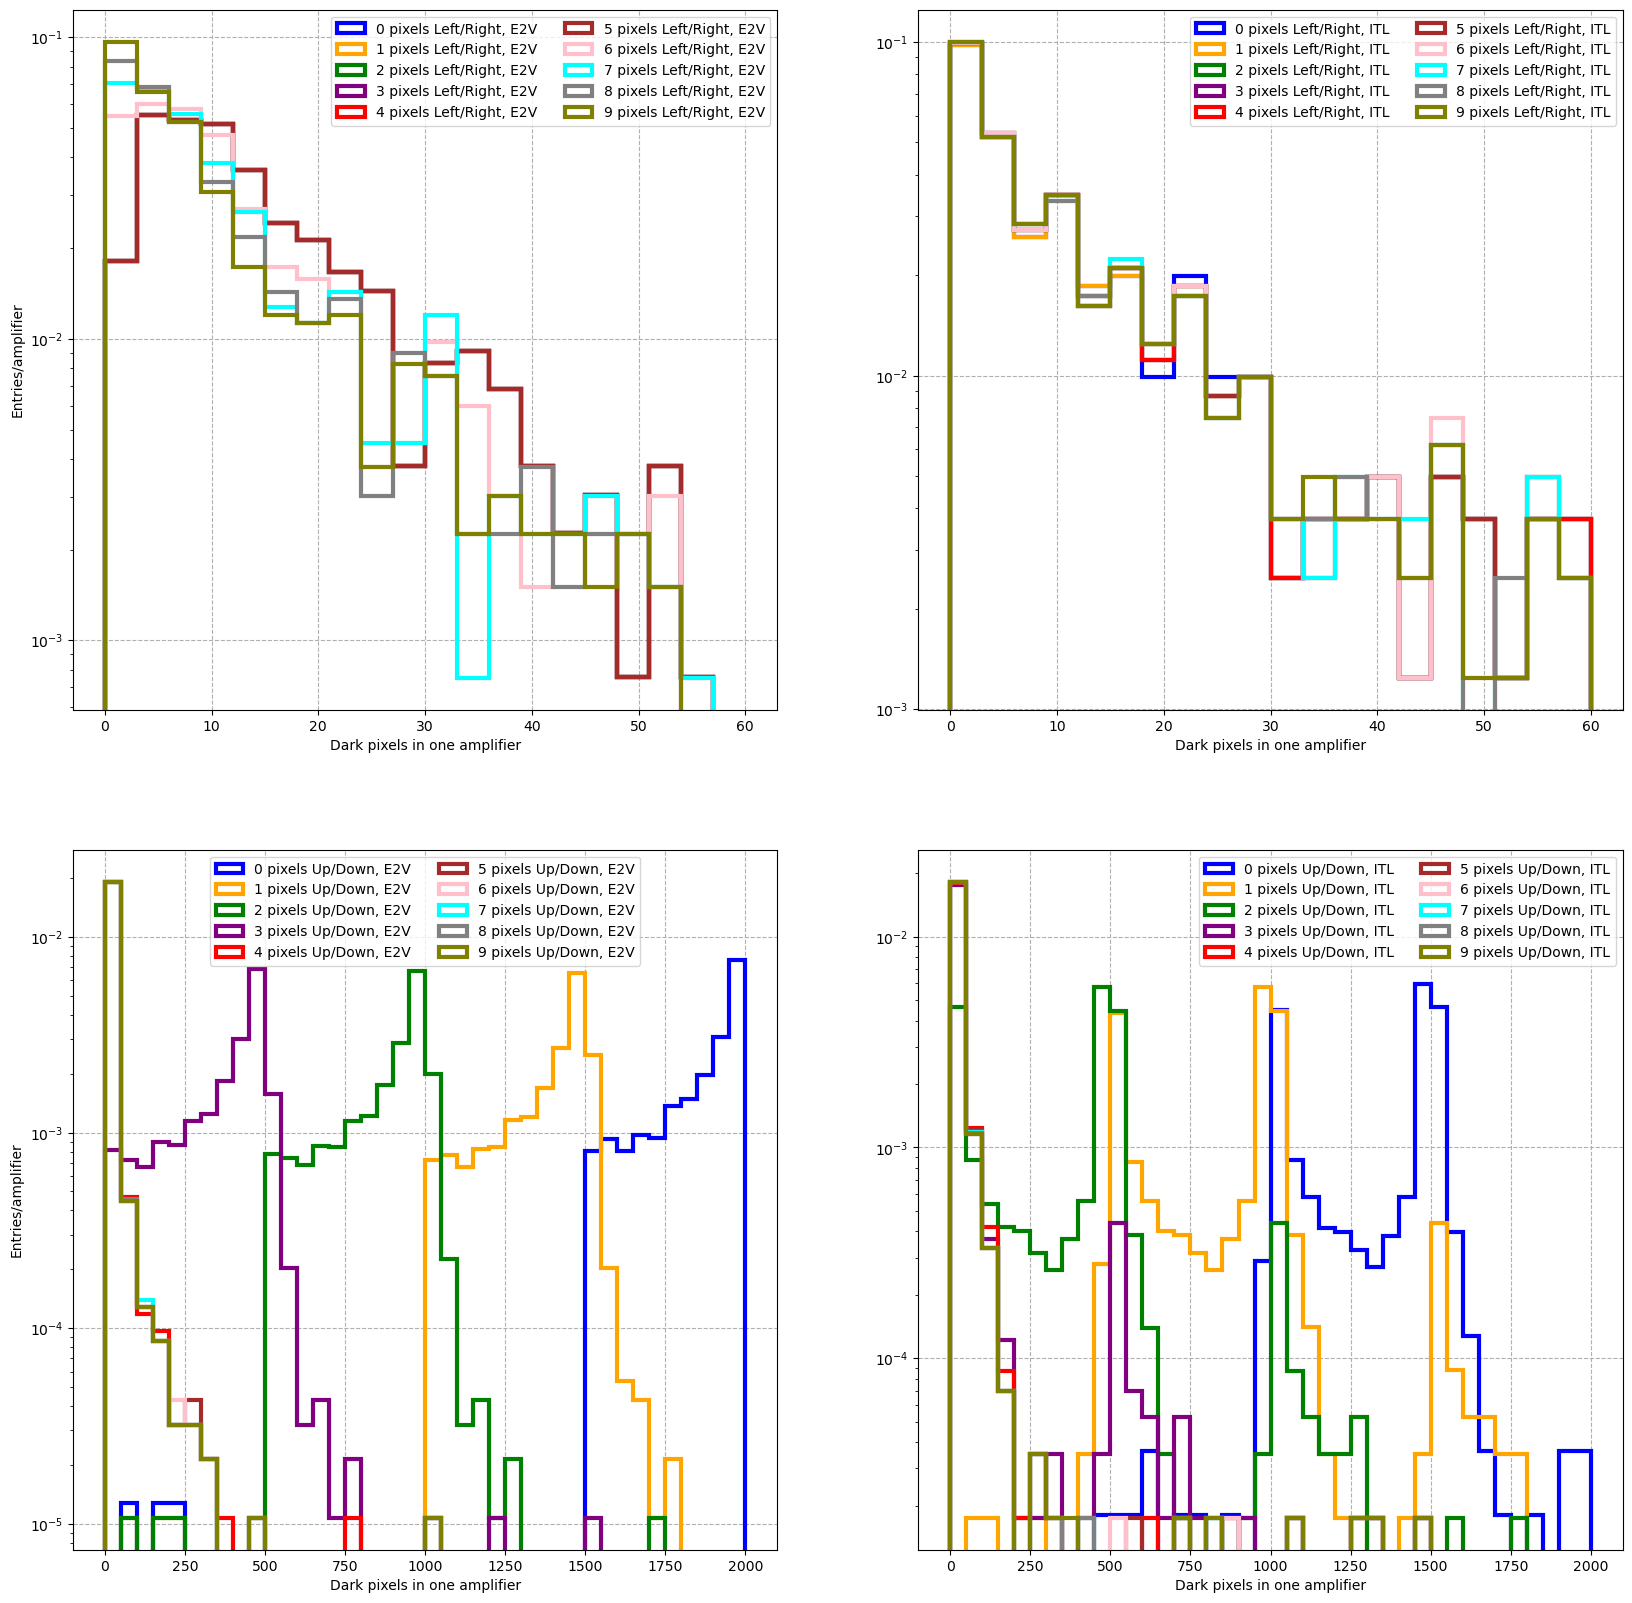

In [43]:
fig,axs = plt.subplots(2,2,figsize=[20,20],sharey=False)

for k,color in zip(range(10),colorArray):
    keyString1 = "9_{}".format(k) # Changing leftRight
    keyString2 = "{}_9".format(k) # Changing upDown

    for key,lbl,ax in zip([keyString1,keyString2],["Left/Right","Up/Down"],axs):
        df = df_dict[key]
        df["MANUFACTURER"] = [myu.det_ptypes[myu.det_nums[x]] for x in df["BAY_SLOT"]]
        dark_pix = df["DARK_PIXELS"]
        dark_cols = df["DARK_COLUMNS"]

        E2V_mask = df["MANUFACTURER"]=="E2V"
        ITL_mask = df["MANUFACTURER"]=="ITL"

        if lbl=="Left/Right":
            edgeAmpMask = np.array([(x[-1]==str(0) or x[-1]==str(7)) for x in df["SEGMENT"]])
            E2V_mask = E2V_mask & edgeAmpMask
            ITL_mask = ITL_mask & edgeAmpMask
            bins = np.arange(0,61,step=3)
        else:
            bins = np.arange(0,2001,step=50)

        # print(np.max(dark_pix[E2V_mask]),np.max(dark_pix[ITL_mask]),np.std(dark_pix[E2V_mask]),np.std(dark_pix[ITL_mask]))

        # if k<:
        ax[0].hist(dark_pix[E2V_mask],bins=bins,label="{} pixels {}, {}".format(k,lbl,"E2V"),histtype='step',color=color,density=True,stacked=True,linewidth=3)
        ax[1].hist(dark_pix[ITL_mask],bins=bins,label="{} pixels {}, {}".format(k,lbl,"ITL"),histtype='step',color=color,density=True,stacked=True,ls='-',linewidth=3)

for ax in axs.flatten():
    ax.semilogy()
    ax.legend(ncols=2)
    ax.grid(ls='--')
    ax.set_xlabel("Dark pixels in one amplifier")
axs[1,0].set_ylabel("Entries/amplifier")
axs[0,0].set_ylabel("Entries/amplifier")

fig.show()

In [48]:
print("Detector type - Amplifier - 50th percentile - 95th percentile")
for manu in ["E2V","ITL"]:
    for seg in np.sort(np.unique(df_dict["9_0"]["SEGMENT"])):
        print(manu,seg,np.percentile(df_dict["9_0"]["DARK_PIXELS"][[x==manu for x in df_dict["9_0"]["MANUFACTURER"]] and df_dict["9_0"]["SEGMENT"]==seg],[50,95]))

Detector type - Amplifier - 50th percentile - 95th percentile
E2V C00 [ 8.  61.6]
E2V C01 [ 4.  47.2]
E2V C02 [ 5.  55.8]
E2V C03 [ 4.  44.6]
E2V C04 [ 4.  48.2]
E2V C05 [ 4.  60.6]
E2V C06 [ 5.  46.4]
E2V C07 [ 7.  57.6]
E2V C10 [  13.  1481.6]
E2V C11 [  5.  130.4]
E2V C12 [ 6.  88.2]
E2V C13 [  5.  393.4]
E2V C14 [  5.  344.2]
E2V C15 [  5.  259.4]
E2V C16 [  7.  124.4]
E2V C17 [ 14.  549.4]
ITL C00 [ 8.  61.6]
ITL C01 [ 4.  47.2]
ITL C02 [ 5.  55.8]
ITL C03 [ 4.  44.6]
ITL C04 [ 4.  48.2]
ITL C05 [ 4.  60.6]
ITL C06 [ 5.  46.4]
ITL C07 [ 7.  57.6]
ITL C10 [  13.  1481.6]
ITL C11 [  5.  130.4]
ITL C12 [ 6.  88.2]
ITL C13 [  5.  393.4]
ITL C14 [  5.  344.2]
ITL C15 [  5.  259.4]
ITL C16 [  7.  124.4]
ITL C17 [ 14.  549.4]


In [64]:
median_arr = []
upper_arr = []
print("Detector type - Amplifier - 50th percentile - 95th percentile")
for key in df_dict.keys():
    df = df_dict[key]
    print(key[0],"pixels")
    for manu in ["E2V","ITL"]:
        for seg in np.sort(["C00","C07","C10","C17"]):
            print(manu,seg,np.percentile(df["DARK_PIXELS"][[x==manu for x in df["MANUFACTURER"]] and df["SEGMENT"]==seg],[50,95]))
            med, upper = np.percentile(df["DARK_PIXELS"][[x==manu for x in df["MANUFACTURER"]] and df["SEGMENT"]==seg],[50,95])
            median_arr.append(med)
            upper_arr.append(upper)

Detector type - Amplifier - 50th percentile - 95th percentile
0 pixels
E2V C00 [1670.  2016.6]
E2V C07 [1676.  2012.6]
E2V C10 [1883. 2039.]
E2V C17 [1896. 2040.]
ITL C00 [1670.  2016.6]
ITL C07 [1676.  2012.6]
ITL C10 [1883. 2039.]
ITL C17 [1896. 2040.]
1 pixels
E2V C00 [1167.  1513.6]
E2V C07 [1173. 1510.]
E2V C10 [1408. 1590.]
E2V C17 [1405.  1661.2]
ITL C00 [1167.  1513.6]
ITL C07 [1173. 1510.]
ITL C10 [1408. 1590.]
ITL C17 [1405.  1661.2]
2 pixels
E2V C00 [ 664.  1010.6]
E2V C07 [ 670.  1008.2]
E2V C10 [ 905. 1503.]
E2V C17 [ 902.  1248.2]
ITL C00 [ 664.  1010.6]
ITL C07 [ 670.  1008.2]
ITL C10 [ 905. 1503.]
ITL C17 [ 902.  1248.2]
3 pixels
E2V C00 [166.  507.6]
E2V C07 [167. 506.]
E2V C10 [ 402.  1473.8]
E2V C17 [399.  845.8]
ITL C00 [166.  507.6]
ITL C07 [167. 506.]
ITL C10 [ 402.  1473.8]
ITL C17 [399.  845.8]
4 pixels
E2V C00 [ 5.  60.4]
E2V C07 [ 5.  57.2]
E2V C10 [   8.  1473.8]
E2V C17 [ 10.  603.4]
ITL C00 [ 5.  60.4]
ITL C07 [ 5.  57.2]
ITL C10 [   8.  1473.8]
ITL C17 [ 1

In [65]:
median_arr = np.array(median_arr)
upper_arr = np.array(upper_arr)

In [66]:
median_arr,upper_arr = np.reshape(median_arr,(-1,4)),np.reshape(upper_arr,(-1,4)) 

In [67]:
np.shape(median_arr)

(38, 4)